In [2]:
import os
import importlib
from timeit import timeit
import logging
import sys
import importlib
import time

import numpy as np
import pandas as pd
import scipy
import h5py
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numba

import ms_utils
import browser
import interface
import ms_database
import ms_run_files

import sandbox

import line_profiler
profile = line_profiler.LineProfiler()
# heat.evolve = profile(heat.evolve)
# profile.print_stats()

def reload():
    importlib.reload(ms_run_files)
    importlib.reload(ms_utils)
    importlib.reload(browser)
    importlib.reload(interface)
    importlib.reload(sandbox)
    importlib.reload(ms_database)

In [ ]:
reload()

inets = []
evis = []
anis = []
# in_folder = "/home/sander/Documents/Proteomics/data/ion_networks"
in_folder = "/home/sander/Documents/Proteomics/data/ecoli3"
# in_folder = "/home/sander/Documents/Proteomics/data/jpt/APEX"
for file_name in ms_utils.get_file_names_with_extension([in_folder], ".inet.hdf"):
    inets.append(
        ms_run_files.Network(
            file_name
        )
    )
    evis.append(
        ms_run_files.Evidence(
            file_name
        )
    )
    anis.append(
        ms_run_files.Annotation(
            file_name
        )
    )

In [ ]:
# ani_indices = anis[0].get_dataset("indices", 'edge_candidates')
ani_indptr = anis[0].get_dataset("indptr", 'edge_candidates')
edge_indptr, edge_indices = inets[0].get_edges(indptr_and_indices=True)

In [ ]:
ani_indptr.shape

<IPython.core.display.Javascript object>


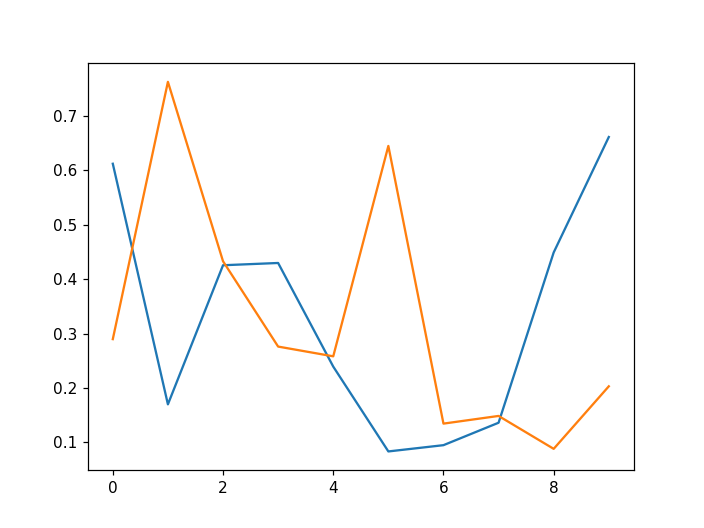

In [7]:
%matplotlib notebook
z=np.random.random((10,2))
plt.plot(z)